<a href="https://colab.research.google.com/github/lustea0201/Underdogs/blob/master/Final_project/Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os 

!rm -rf predictions
os.mkdir("predictions")


from google.colab import drive
drive.mount('/content/drive/')

import zipfile
data = zipfile.ZipFile("/content/drive/My Drive/Super Resolution/data.zip", 'r')

data.extractall()
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# NEED TO RENAME ALL FILES

def rename(shape, number):
  base_h = "/content/data/" + shape + "_" + number + "/High/Images/"
  base_l = "/content/data/" + shape + "_" + number + "/Low/Images/"
  if shape == "circle": 
    base_h += "Circle_" + number + "_"
    base_l += "Circle_" + number + "_"
  else:
    base_h += "Irregular_" + number + "_"
    base_l += "Irregular_" + number + "_"
  for i in range(1,201): 
    src = base_h + str(i) + ".tif"
    drt = "/content/data/" + shape + "_" + number + "/High/Images/" + str(i).zfill(3) + ".tif"
    os.rename(src,drt)
    src = base_l + str(i) + ".tif"
    drt = "/content/data/" + shape + "_" + number + "/Low/Images/" + str(i).zfill(3) + ".tif"
    os.rename(src,drt)

In [26]:
import torch
import torch.nn as nn
import torch.nn.init as init

device = 'cpu'


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

model = Net(upscale_factor=2)
model.load_state_dict(torch.load('drive/My Drive/Super Resolution/model_augmented3.pth', map_location = torch.device('cpu'))) 


<All keys matched successfully>

In [0]:
from torchvision.datasets import ImageFolder
from torchvision import transforms



N_test = 30 


In [0]:
from imageio  import imwrite
import numpy as np 
import os 


for shape in ["irregular", "circle"]: 
  for number in ["1", "16", "32", "64"]: 
    rename(shape, number)

    X_t = ImageFolder(root = "/content/data/" + shape + "_" + number + "/Low", transform = transforms.ToTensor())
    Y_t = ImageFolder(root = "/content/data/" + shape + "_" + number + "/High", transform = transforms.ToTensor())
    test = []

    for i in range(N_test):
      test.append([X_t[i][0], Y_t[i][0]])
    test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1)

    folder_path = "predictions/" + shape + "_" + number
    os.mkdir(folder_path)
    originals, truths, predictions = [], [], []
    i = 1
    with torch.no_grad():
      for batch in test_loader:
          input_, target = batch[0].to(device), batch[1].to(device)
          originals.append(input_)
          pred = model(input_)
          predictions.append(pred)
          truths.append(target)
          im = (255*(pred[0].permute(1,2,0).numpy())).astype(np.uint8)
          imwrite(folder_path + "/" + shape + "_" + number + "_%d.tif" %(i), im)
          i += 1

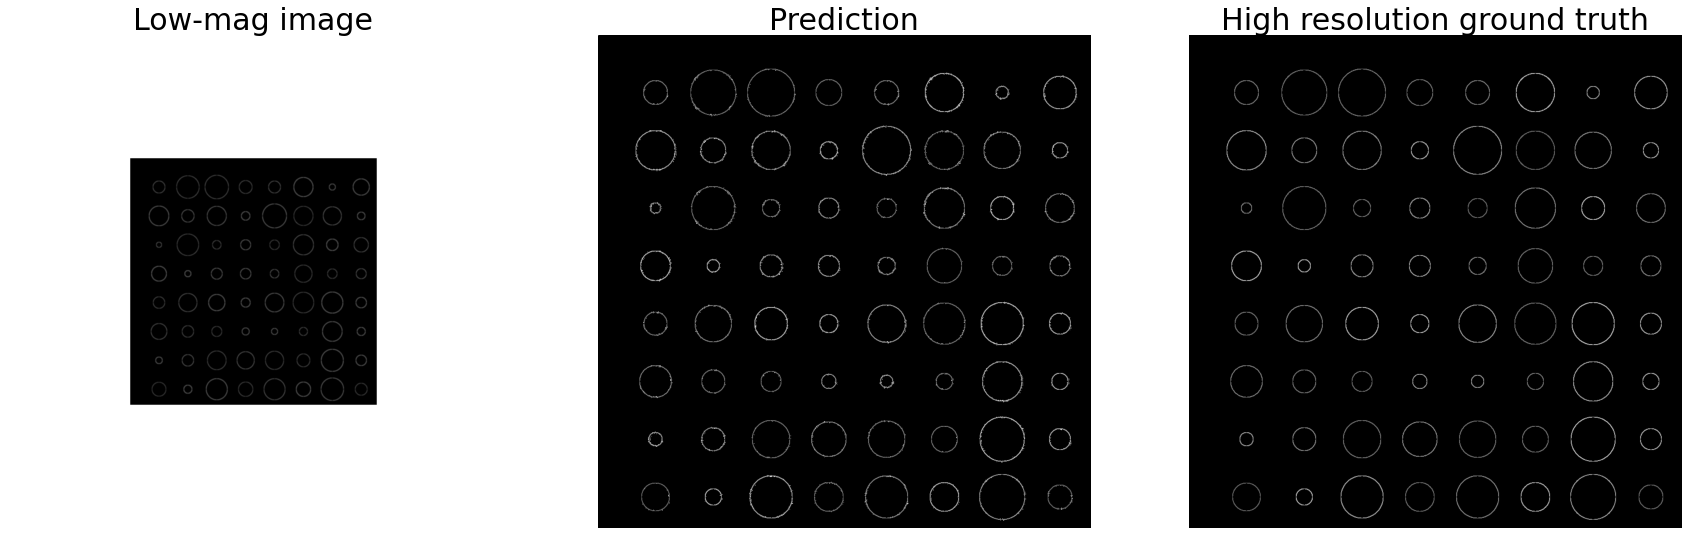

In [29]:
import matplotlib.pyplot as plt 

def compare(o,p,t): 
  fig, axes = plt.subplots(1,3, figsize=(30,15))

  op = torch.ones(t.shape)
  height = t.shape[1]
  width = t.shape[1]
  op[:, height//4:height-height//4, width//4:width-width//4] = o

  op = (255*op.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[0].imshow(op)
  axes[0].set_title("Low-mag image", fontsize=30);
  axes[0].axis('off')
  
  p = (255*p.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[1].imshow(p)
  axes[1].set_title("Prediction", fontsize=30);
  axes[1].axis('off')

  t = (255*t.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[2].imshow(t)
  axes[2].set_title("High resolution ground truth", fontsize=30);
  axes[2].axis('off')
  
compare(originals[0][0], predictions[0][0], truths[0][0])

In [31]:
download = input("Do you want to download these predictions ? (y or n)")
if (download == "y"):
  !zip -r /content/file.zip /content/predictions
  from google.colab import files
  files.download("/content/file.zip")

Do you want to download these predictions ? (y or n)y
updating: content/predictions/ (stored 0%)
updating: content/predictions/irregular_64/ (stored 0%)
updating: content/predictions/irregular_64/irregular_64_6.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_26.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_9.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_8.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_20.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_1.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_22.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_3.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_4.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_28.tif (deflated 97%)
updating: content/predictions/irregular_64/irregular_64_15.tif (deflated 